# Biomedical AI Sentiment Analysis

This project focuses on building a sentiment analysis pipeline for biomedical and healthcare-related AI text. The goal is to automatically classify sentences into positive, neutral, or negative sentiments.

Install and import the tools required to:
load HuggingFace dataset
process text
visualize results
train and evaluate ML models later



In [130]:
#Install required libraries
!pip install datasets transformers torch scikit-learn pandas matplotlib seaborn


# Libraries used

datasets → loads HuggingFace dataset easily  

transformers → for pretrained NLP models (BERT etc.)  

torch → deep learning backend used by transformers  

scikit-learn → evaluation metrics + ML utilitie  

pandas → tables + data analysis  

matplotlib/seaborn → charts & visualization

In [132]:
# import the core libraries so we can start using them
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset


### Loading the Dataset 

Load_dataset(..)
Connects to hugging face servers
Downloads the dataset and loads it into a structured format called a DatasetDict, it contains:
Split like: train , test and validation 

In [134]:
dataset = load_dataset("Shekswess/ai-healthcare-biomedical-sentiment")
dataset


DatasetDict({
    train: Dataset({
        features: ['keyword', 'topic', 'language', 'prompt', 'label'],
        num_rows: 100
    })
})

In [135]:
# view first 5 rows 
dataset["train"][0:5]


{'keyword': ['biomedical research methods',
  'clinical decision support systems',
  'biomedical signal processing',
  'biological data mining',
  'biomedical cybernetic systems'],
 'topic': ['Artificial Intelligence',
  'Artificial Intelligence',
  'Artificial Intelligence',
  'Artificial Intelligence',
  'Artificial Intelligence'],
 'language': ['English', 'English', 'English', 'English', 'English'],
 'prompt': ['The integration of artificial intelligence in biomedical research methods has been a topic of discussion among scientists, with various studies exploring its potential applications and limitations.',
  'The integration of clinical decision support systems in healthcare has significantly improved patient outcomes by providing doctors with real-time, evidence-based recommendations.',
  'Biomedical signal processing is a field that involves the use of various techniques to analyze and interpret signals from the human body, which has numerous applications in medical diagnosis an

# Key observations 
Dataset has only **train split**  
100 rows shows its a small dataset  
Columns:'keyword', 'topic',' language', 'prompt',' label'  
And the actual text we’ll analyze is clearly the prompt column.


### Converting Dataset to DataFrame
Pandas is easier for exploration  
easier to visualize  
easier to clean and preprocess  
easier to build portfolio-ready analysis

In [138]:
df = pd.DataFrame(dataset["train"])
df.head()


,keyword,topic,language,prompt,label
0,biomedical research methods,Artificial Intelligence,English,The integration of artificial intelligence in ...,neutral
1,clinical decision support systems,Artificial Intelligence,English,The integration of clinical decision support s...,positive
2,biomedical signal processing,Artificial Intelligence,English,Biomedical signal processing is a field that i...,neutral
3,biological data mining,Artificial Intelligence,English,The integration of biological data mining and ...,positive
4,biomedical cybernetic systems,Artificial Intelligence,English,The integration of biomedical cybernetic syste...,negative


In [139]:
df.shape

(100, 5)

#### Checking sentiment label distribution
Before training any model, we must check if the dataset is balanced.

Because if we have like:

90 positive

5 negative

5 neutral

Then accuracy will be misleading.

In [141]:
# counts samples in each sentiment class 
df["label"].value_counts()

# shows our dataset is well-balanced 

label
positive    36
negative    33
neutral     31
Name: count, dtype: int64

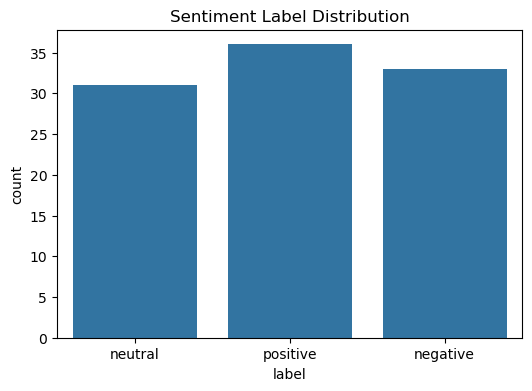

In [142]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label")
plt.title("Sentiment Label Distribution")
plt.show()


#### Text Length Analysis (Understanding the Data)

Now we analyze the length of each prompt.  
Why?  
Because:
ML models behave differently with short vs long text  
helps decide preprocessing steps  
helps decide max sequence length later (important for BERT)

From the output below, we understand that :
Average prompt length ≈ 25 words  
The longest is 44 words  
Shortest is 17 words  

This means the dataset is short-text sentiment classification, which is ideal for models like Logistic Regression, SVM, and BERT.

In [144]:
df["text_length"] = df["prompt"].apply(lambda x: len(x.split())) # x.split() breaks the sentence into words 
                                                                 # len() counts the number of words
df[["prompt", "text_length"]].head()                             # store in new column called text_length


,prompt,text_length
0,The integration of artificial intelligence in ...,26
1,The integration of clinical decision support s...,21
2,Biomedical signal processing is a field that i...,44
3,The integration of biological data mining and ...,27
4,The integration of biomedical cybernetic syste...,24


In [145]:
df["text_length"].describe()


count    100.000000
mean      25.160000
std        4.953766
min       17.000000
25%       21.750000
50%       25.000000
75%       27.000000
max       44.000000
Name: text_length, dtype: float64

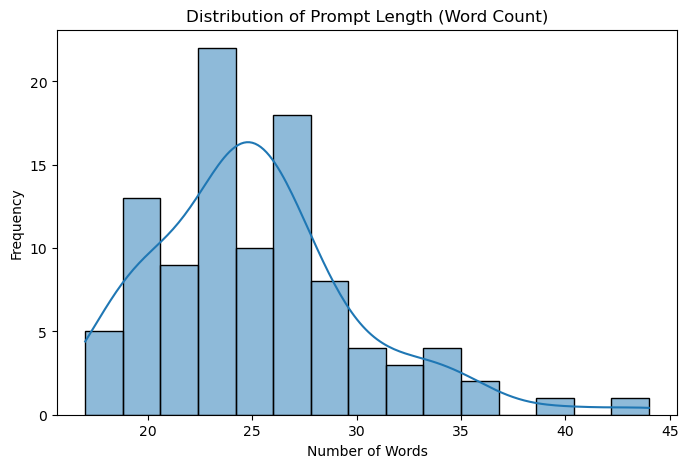

In [146]:
#A histogram showing most prompts cluster around some word length

plt.figure(figsize=(8,5))
sns.histplot(df["text_length"], bins=15, kde=True)
plt.title("Distribution of Prompt Length (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()





### Text Cleaning 
We clean the prompt text. Raw text may include:
punctuation noise,
inconsistent casing,
extra spaces,
symbols,

Cleaning improves performance for traditional ML models (TF-IDF + Logistic Regression).

Note: For Transformers (BERT), heavy cleaning is not always needed — but basic cleaning is still okay.

In [148]:
### Create a clean text column 
import re

def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

df["clean_prompt"] = df["prompt"].apply(clean_text)

df[["prompt", "clean_prompt"]].head()


,prompt,clean_prompt
0,The integration of artificial intelligence in ...,the integration of artificial intelligence in ...
1,The integration of clinical decision support s...,the integration of clinical decision support s...
2,Biomedical signal processing is a field that i...,biomedical signal processing is a field that i...
3,The integration of biological data mining and ...,the integration of biological data mining and ...
4,The integration of biomedical cybernetic syste...,the integration of biomedical cybernetic syste...


In [149]:
(df["clean_prompt"].str.len() == 0).sum()


0

Now your dataset has both:

raw prompt (prompt)

cleaned prompt (clean_prompt)

#### Encode Sentiment Labels into Numbers

Machine learning models don’t understand text labels like:

"positive"

"neutral"

"negative"

They need numeric labels like:

0, 1, 2

In [152]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()                                 # Converts categorical labels into numbers 
df["label_encoded"] = label_encoder.fit_transform(df["label"]) # learns the mapping (fit) and applies the mapping (transform)

df[["label", "label_encoded"]].head(10)




,label,label_encoded
0,neutral,1
1,positive,2
2,neutral,1
3,positive,2
4,negative,0
5,positive,2
6,positive,2
7,positive,2
8,negative,0
9,negative,0


In [153]:
# quality check
#when your model predicts 2, you know it means "positive."
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping


{'negative': 0, 'neutral': 1, 'positive': 2}

#### Train/Test Split (Create Evaluation Setup)

Right now, we only have training data.
To make this a real ML project, we must split it into:  
Train set (model learns patterns)  
Test set (model is evaluated on unseen data)  

Since the dataset has 100 rows:  
Training samples: 80  
Testing samples: 20

In [155]:
from sklearn.model_selection import train_test_split

X = df["clean_prompt"]   #input text (features)
y = df["label_encoded"]  #target output (what we want to predict)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% testingg and 80% training
    random_state=42, #Ensures reproducibility (same split every run)
    stratify=y      # keeps the label distribution balanced in train/test and prevents the test set from accidentally having mostly one label 
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 80
Testing samples: 20


In [156]:
print("Train label distribution:")
print(y_train.value_counts())

print("\nTest label distribution:")
print(y_test.value_counts())


Train label distribution:
label_encoded
2    29
0    26
1    25
Name: count, dtype: int64

Test label distribution:
label_encoded
0    7
2    7
1    6
Name: count, dtype: int64


In [157]:
### Intrepreting 
# Train set is balanced-ish (29/26/25)

#Test set is also balanced (7/7/6)


### Convert Text into TF-IDF Features

Now we transform text into numbers using TF-IDF.

🎯 Why TF-IDF?

Machine learning models cannot understand raw words.
TF-IDF converts text into a numeric matrix based on:

TF (Term Frequency) → how often a word appears in a sentence

IDF (Inverse Document Frequency) → downweights common words like “the”, “is”, “and”

So words that matter more become more important.

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=2000, #limits vocabulary size to top 2000 important words/phrases, prevents overfitting, keeps document official.
    ngram_range=(1,2), # unigram(single word"healthcare"), bigram (two-word phrases- "machine learning") improves sentiment detection - phrases carry meaning
    stop_words="english" # removes common words -the m is and , of
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)


TF-IDF Train Shape: (80, 1223)
TF-IDF Test Shape: (20, 1223)


In [160]:
#first 20 feature names
tfidf.get_feature_names_out()[:20]


array(['accelerate', 'accelerate discoveries', 'accelerating',
       'accelerating medical', 'access', 'access lifesaving', 'accuracy',
       'accuracy allowing', 'accuracy clinical', 'accuracy efficiency',
       'accuracy reliability', 'accuracy worrying', 'accurate',
       'accurate ai', 'accurate analysis', 'accurate diagnoses',
       'accurate efficient', 'accurate predictions', 'accurate timely',
       'accurately'], dtype=object)

We now have 1223 features (words+bigrams)
This is a good size : not too small , not too big 

#### Train a Logistic Regression Model (Baseline Classifier)

Now we train our first real sentiment classifier.  
Why Logistic Regression?  
Because it’s:  
fast  
interpretable  
strong baseline for text classification

In [165]:
from sklearn.linear_model import LogisticRegression #This model learns patterns from TF-IDF features to classify sentiment.

model = LogisticRegression(max_iter=1000) #Sometimes text data needs more iterations to converge. This prevents convergence warnings.

model.fit(X_train_tfidf, y_train) #This is where learning happens: it sees training text, learns relationships between words and sentiment labels

print("Model training completed!")


Model training completed!


In [166]:
# MAKE predictions 
y_pred = model.predict(X_test_tfidf)

y_pred[:10]


array([0, 2, 0, 0, 0, 2, 0, 1, 2, 0])

### Evaluate Model Performance (Accuracy + Report)

Now we measure how good the model actually is.  
Percentage of correct predictions: accuracy = correct predictions /total predictions   
If accuracy is 0.70 - model is correct 70% of the time 



In [168]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9


##### 0.9 over accuracy means out of 20 test samples , model predicted correctly  about:
##### 0.90 x 20= 18
##### i.e 18 predictions correctly ad 2 wrong shows a strong performance 


#### Detailed performance report 
Classification report gives:

precision (how correct predictions are)

recall (how many actual items were found)

f1-score (balance of precision & recall)

In [171]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

    negative       0.78      1.00      0.88         7
     neutral       1.00      0.67      0.80         6
    positive       1.00      1.00      1.00         7

    accuracy                           0.90        20
   macro avg       0.93      0.89      0.89        20
weighted avg       0.92      0.90      0.90        20



##### Metrics show per sentiment class
Negative: Recall (1.00) -The model correctly identifies all negative samples.  
           Precision 0.78 - some predicted as negative were actually neutral/positive   
           
Neutral: Recall = 0.67 -Whenever the model predicts "neutral", it is always correct.  
           Recall 0.67 means: It only found about 67% of the actual neutral samples.  
           
So the model misses some neutral cases and likely labels them as positive or negative.  
Neutral is usually the hardest sentiment to classify.  

Positive Sentiment: All positive samples were classified correctly.

##### Macro Avg Vs Weighted Avg 
Macro Average   
Treats each class equally (even if data is imbalanced), Good for checking fairness across classes.  
Weighted Average  
Weights based on support size.  
More realistic overall performance.  
Both are high here → good sign.  

###  Confusion Matrix

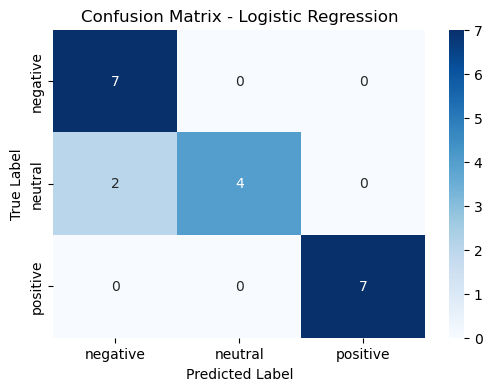

In [174]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Since accuracy is 0.90, the confusion matrix likely shows:

only 2 misclassifications

most predictions lie on the diagonal (correct)

#### Summary 
The Logistic Regression model trained using TF-IDF achieved 90% accuracy on the test set. It performed exceptionally well on positive sentiment (F1-score = 1.00) and negative sentiment (F1-score = 0.88). Neutral sentiment was slightly harder to detect (Recall = 0.67), indicating the model occasionally misclassified neutral statements as positive or negative.

#### Train an SVM Model (and Evaluate It)

SVM (Support Vector Machine) is often one of the best models for text classification with TF-IDF.

In [178]:
from sklearn.svm import LinearSVC #SVM works well in high-dimensional spaces like TF-IDF where we have hundreds or thousands of word features.

svm_model = LinearSVC()

svm_model.fit(X_train_tfidf, y_train) #Trains the SVM model using training text vectors.

print("SVM model training completed!")


SVM model training completed!


In [179]:
#  Make predictions 
svm_pred = svm_model.predict(X_test_tfidf)
svm_pred[:10]


array([0, 2, 0, 0, 0, 2, 0, 1, 2, 0])

In [183]:
#### Evaluate SVM Performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

print("\nClassification Report (SVM):")
print(classification_report(y_test, svm_pred, target_names=label_encoder.classes_))


SVM Accuracy: 0.9

Classification Report (SVM):
              precision    recall  f1-score   support

    negative       0.78      1.00      0.88         7
     neutral       1.00      0.67      0.80         6
    positive       1.00      1.00      1.00         7

    accuracy                           0.90        20
   macro avg       0.93      0.89      0.89        20
weighted avg       0.92      0.90      0.90        20



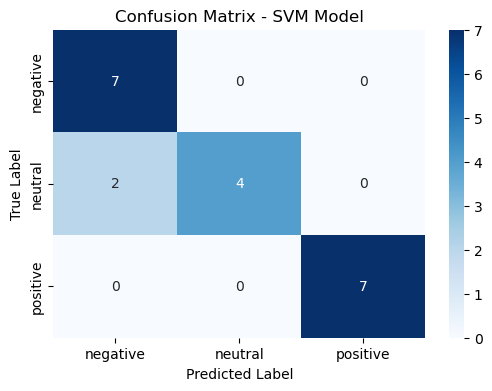

In [186]:
svm_cm = confusion_matrix(y_test, svm_pred)

plt.figure(figsize=(6,4))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix - SVM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#Accuracy tells overall correctness

#Classification report tells performance per class (precision/recall/f1)

SVM produced the exact same performance as Logistic Regression (accuracy 0.90 and same metrics).

That tells us:

Dataset is small + very clean

Both models learned similar decision boundaries

Your TF-IDF features are strong

#### Compare Logistic Regression vs SVM

In [192]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM (LinearSVC)"],
    "Accuracy": [accuracy, svm_accuracy]
})

results


,Model,Accuracy
0,Logistic Regression,0.9
1,SVM (LinearSVC),0.9


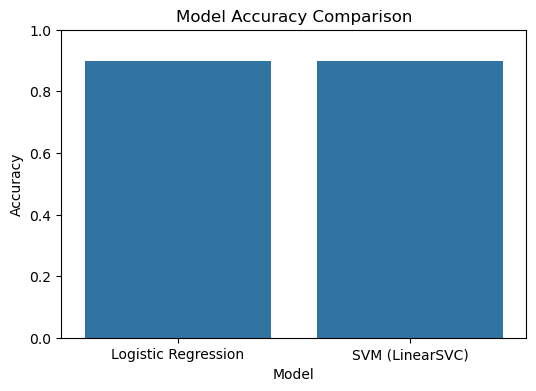

In [198]:
plt.figure(figsize=(6,4))
sns.barplot(data=results, x="Model", y="Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.show()


Save the Model and TF-IDF Vectorizer
Why do we save them?

Because in real-world ML projects:

You don’t retrain the model every time

You save the trained model

later you load it and predict instantly





In [205]:
!pip install joblib


In [209]:
import joblib

joblib.dump(model, "sentiment_model_logreg.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved successfully!")

# Saves your trained model into a .pkl file
# Saves the TF-IDF vectorizer too (VERY important)
# Because without the vectorizer, your model can’t understand raw text

Model and vectorizer saved successfully!


In [211]:
import os
os.listdir()


['.ipynb_checkpoints',
 'Charts.ipynb',
 'Coffee.ipynb',
 'coffee_production_report.png',
 'dataframe.ipynb',
 'diabetic_readmission.ipynb',
 'DICT.ipynb',
 'flow.ipynb',
 'Functions.ipynb',
 'High_Risk_prediction_ML.ipynb',
 'Hospital_readmission.ipynb',
 'HotelRevenueProject.ipynb',
 'Intro.ipynb',
 'LIST.ipynb',
 'master_risk_table.csv',
 'med.ipynb',
 'nhanes_2017_2018_master.csv',
 'NLP.ipynb',
 'noshow.ipynb',
 'noshow_cleaned_for_sql.csv',
 'noshow_create_table.sql',
 'NumPy.ipynb',
 'patient_risk_master.csv',
 'patient_risk_master.db',
 'practice1.ipynb',
 'Practice2.ipynb',
 'practice3df.ipynb',
 'Practice4.ipynb',
 'Project1.ipynb',
 'readmission_by_dx.csv',
 'readmission_dashboard_data.csv',
 'Riskstratification.ipynb',
 'sentiment_model_logreg.pkl',
 'SET.ipynb',
 'tfidf_vectorizer.pkl',
 'Untitled.ipynb']

#### Load the Saved Model & Make a Prediction Function

Now we’ll prove the model can be reused

In [216]:
loaded_model = joblib.load("sentiment_model_logreg.pkl")
loaded_tfidf = joblib.load("tfidf_vectorizer.pkl")

print("Model and vectorizer loaded successfully!")


Model and vectorizer loaded successfully!


This simulates a real-world situation where:

model was trained earlier

later we load it in a new script/app and use it

#### Create a Sentiment Prediction Function


In [221]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = loaded_tfidf.transform([cleaned])
    prediction = loaded_model.predict(vectorized)[0]
    sentiment = label_encoder.inverse_transform([prediction])[0]
    return sentiment


This function:

cleans the input text

converts it into TF-IDF numbers

uses the trained model to predict label

converts numeric label back to word (positive/neutral/negative)

In [225]:
# Test the function
sample_text = "AI is improving early cancer diagnosis and reducing medical errors."
print("Prediction:", predict_sentiment(sample_text))


Prediction: positive


In [226]:
test_samples = [
    "AI is improving patient outcomes in hospitals.",
    "The use of AI raises serious ethical concerns about privacy.",
    "AI is being explored in healthcare but results are still unclear."
]

for text in test_samples:
    print(text)
    print("Sentiment:", predict_sentiment(text))
    print("-" * 50)


AI is improving patient outcomes in hospitals.
Sentiment: positive
--------------------------------------------------
The use of AI raises serious ethical concerns about privacy.
Sentiment: negative
--------------------------------------------------
AI is being explored in healthcare but results are still unclear.
Sentiment: negative
--------------------------------------------------


In [227]:
demo_df = pd.DataFrame({
    "Text": test_samples
})

demo_df["Predicted Sentiment"] = demo_df["Text"].apply(predict_sentiment)

demo_df


,Text,Predicted Sentiment
0,AI is improving patient outcomes in hospitals.,positive
1,The use of AI raises serious ethical concerns ...,negative
2,AI is being explored in healthcare but results...,negative


It clearly shows:

Input text → what the user sees

Predicted sentiment → what the model predicts

# Conclusion 
In this project, we built a sentiment analysis pipeline for biomedical AI-related text.
The pipeline includes data cleaning, TF-IDF feature extraction, and training two models: Logistic Regression and Linear SVM.
Both models achieved 90% accuracy on the test set, with strong performance for positive and negative sentiments, and slightly lower recall for neutral sentiment.
We also saved the trained model and TF-IDF vectorizer and created a reusable prediction function for real-time sentiment analysis.